# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
with open(r"D:\desktop\Pankaj_New_OpenAI_Key.txt", "r") as file:
    OPENAI_API_KEY = file.read().strip()



Note: LLM's do not always produce the same results. When executing the code in your notebook, you may get slightly different answers that those in the video.

In [ ]:
#!pip install pandas

In [5]:
import pandas as pd
df = pd.read_csv("D:\desktop\Lang_Chain\Data.csv")

In [7]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillow Inserts,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld,"I loved this product, but they only seem to la..."


## LLMChain

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [10]:
llm = ChatOpenAI(temperature=0.9, 
                 model="gpt-3.5-turbo", 
                 timeout=30,
                openai_api_key=OPENAI_API_KEY)

In [11]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {Product}?"
)

In [15]:
chain = prompt | llm

In [ ]:
#Product = "Queen Size Sheet Set"

In [17]:
response =chain.invoke({"Product": "Queen Size Sheet Set"})
print(response.content)

"Royal Comfort Linens"


In [19]:
response =chain.invoke({"Product": "Luxury Air Mattress"})
print(response.content)

Opulence Air Beds


## SimpleSequentialChain

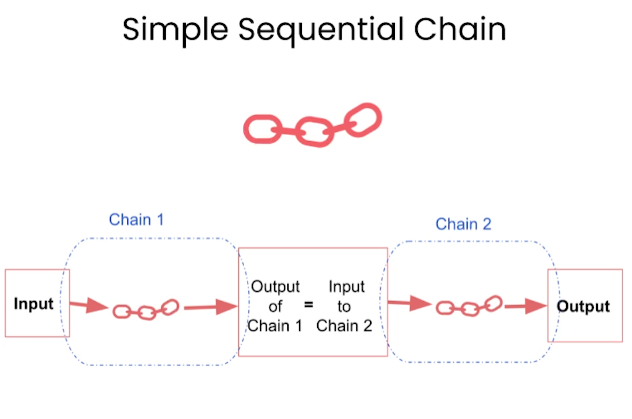

In [21]:
from langchain_core.runnables import RunnableSequence

In [23]:
# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {Product}?"
)

# Chain 1
chain_one = first_prompt | llm

In [27]:
response =chain_one.invoke({"Product": "Luxury Air Mattress"})
print(response.content)

The best name to describe a company that makes luxury air mattresses would be "CloudComfort Luxe Air Beds."


In [25]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = second_prompt | llm

In [29]:
response =chain_two.invoke({"company_name": "Luxury Air Mattress"})
print(response.content)

High-end air mattress company offering premium comfort and durability with luxurious features for a luxurious night's sleep. Perfect for travelers.


In [31]:
overall_simple_chain = RunnableSequence(chain_one, chain_two)                        
                                            

In [35]:
response = overall_simple_chain.invoke({"Product": "Luxury Air Mattress"})
print(response.content)

Opulent Rest provides luxurious bedding and home decor to create a peaceful and elegant sanctuary for a restful night's sleep.


## SequentialChain

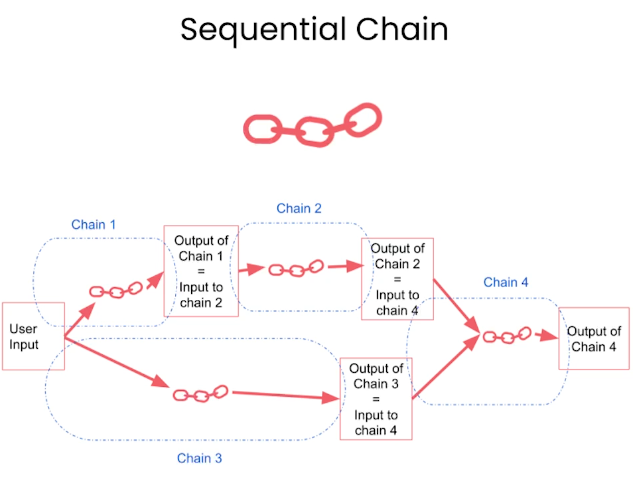

In [37]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [39]:
# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = first_prompt| llm | StrOutputParser() 
                     
chain_one_named = RunnablePassthrough.assign(
    English_Review=chain_one
)

In [41]:
chain_one_named.invoke({"Review": "C'est un excellent produit"})

{'Review': "C'est un excellent produit",
 'English_Review': 'This is an excellent product.'}

In [43]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = second_prompt | llm | StrOutputParser() 
                     
chain_two_named = RunnablePassthrough.assign(
    summary=chain_two
)

In [45]:
chain_two_named.invoke({"English_Review": "This is an excellent product"})

{'English_Review': 'This is an excellent product',
 'summary': 'This product is highly recommended and performs exceptionally well.'}

In [47]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = third_prompt| llm | StrOutputParser() 
                       

In [49]:
chain_three_named = RunnablePassthrough.assign(
    language=chain_three
)

In [51]:

chain_three_named.invoke({
    "Review": "C'est un excellent produit"
})


{'Review': "C'est un excellent produit", 'language': 'French'}

In [53]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = fourth_prompt | llm | StrOutputParser() 
chain_four_named = RunnablePassthrough.assign(
    followup_message=chain_four
)                      


In [55]:
chain_four_named.invoke({
    "summary": "This is a very positive review.",
    "language": "French"
})                     

{'summary': 'This is a very positive review.',
 'language': 'French',
 'followup_message': 'Cher(e) critique, merci pour vos mots positifs et encourageants. Votre soutien est très apprécié et nous sommes ravis de savoir que vous avez apprécié notre travail. Nous espérons vous revoir bientôt et vous offrir une expérience encore plus agréable. Merci encore pour votre soutien et votre avis positif.'}

In [57]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = (
    RunnablePassthrough.assign(English_Review=chain_one)
    .assign(summary=chain_two)
    .assign(language=chain_three)
    .assign(followup_message=chain_four)
)

In [59]:
overall_chain.invoke({"Review": "C'est un excellent produit"})

{'Review': "C'est un excellent produit",
 'English_Review': 'It is an excellent product',
 'summary': 'The product is highly recommended due to its exceptional quality.',
 'language': 'French',
 'followup_message': "Je suis ravi d'apprendre que le produit est fortement recommandé en raison de sa qualité exceptionnelle. Cela confirme mes attentes et me donne encore plus envie de l'essayer. Merci pour cette recommandation!"}

In [ ]:
review = df.Review[2]
overall_chain.invoke({"Review": review})

In [61]:
df["output"] = df["Review"].apply(lambda x: overall_chain.invoke({"Review": x}))


In [65]:
df["output"][0]

{'Review': 'I ordered a king size set. My only criticism was that the sheets were a bit thin but overall comfortable.',
 'English_Review': 'He pedido un juego de tamaño king. Mi única crítica fue que las sábanas eran un poco delgadas pero en general cómodas.',
 'summary': 'The reviewer ordered a king-sized set and found the sheets to be a bit thin but comfortable overall.',
 'language': 'English',
 'followup_message': 'Thank you for providing feedback on your recent purchase of the king-sized sheet set. We are pleased to hear that you found the sheets to be comfortable overall. We will take note of your comment about the thickness of the sheets and consider ways to improve in the future. Thank you for your input!'}

In [63]:
df.head()

,Product,Review,output
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...,{'Review': 'I ordered a king size set. My only...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi...","{'Review': 'I loved the waterproof sac, althou..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...,{'Review': 'This mattress had a small hole in ...
3,Pillow Inserts,This is the best throw pillow fillers on Amazo...,{'Review': 'This is the best throw pillow fill...
4,Milk Frother Handheld,"I loved this product, but they only seem to la...","{'Review': 'I loved this product, but they onl..."


## Router Chain

In [67]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [ ]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [69]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableBranch


In [71]:

parser = StrOutputParser()


In [73]:
physics_chain = ChatPromptTemplate.from_template(physics_template) | llm | parser
math_chain = ChatPromptTemplate.from_template(math_template) | llm | parser
history_chain = ChatPromptTemplate.from_template(history_template) | llm | parser
cs_chain = ChatPromptTemplate.from_template(computerscience_template) | llm | parser

default_chain = ChatPromptTemplate.from_template("{input}") | llm | parser



In [75]:
router_prompt = ChatPromptTemplate.from_template("""
You are a classifier.

Classify the following question into one of these categories:
- physics
- math
- history
- computer science

Return ONLY the category name.

Question: {input}
""")


In [77]:
router_chain = router_prompt | llm | parser


In [79]:
chain = (
    {"topic": router_chain, "input": lambda x: x["input"]}
    | RunnableBranch(
        (lambda x: "physics" in x["topic"].lower(), physics_chain),
        (lambda x: "math" in x["topic"].lower(), math_chain),
        (lambda x: "history" in x["topic"].lower(), history_chain),
        (lambda x: "computer" in x["topic"].lower(), cs_chain),
        default_chain,
    )
)


In [81]:
chain.invoke({"input": "What is black body radiation?"})

"Black body radiation is the electromagnetic radiation emitted by a perfect black body, which is an idealized object that absorbs all incoming light and does not reflect or transmit any light. The radiation emitted by a black body depends only on its temperature, and the spectrum of this radiation follows a specific pattern known as the Planck's law. This type of radiation is important in understanding concepts such as thermal radiation and the behavior of objects at different temperatures."

In [85]:
chain.invoke({"input": "What is 2 + 2?"})

'The answer to 2 + 2 is 4.'

In [87]:
chain.invoke({"input": "Who was Napoleon?"})

"Napoleon Bonaparte was a French military and political leader who rose to prominence during the French Revolution. He became Emperor of the French in 1804 and led France in a series of wars against various European coalitions. He is considered one of the greatest military commanders in history and his empire expanded across much of continental Europe before his defeat at the Battle of Waterloo in 1815. Napoleon's impact on world history is significant, as he introduced many reforms in France and across Europe, leaving a lasting legacy on the political and military landscape of the 19th century."

In [89]:
chain.invoke({"input": "Explain quicksort"})

'Quicksort is a popular sorting algorithm that follows the divide and conquer strategy. It works by selecting a pivot element from the array and partitioning the other elements into two sub-arrays according to whether they are less than or greater than the pivot. The sub-arrays are then recursively sorted.\n\nHere is a step-by-step explanation of how quicksort works:\n\n1. Choose a pivot element from the array. This can be any element, but typically the middle element is chosen.\n2. Partition the array into two sub-arrays: one containing elements less than the pivot and one containing elements greater than the pivot.\n3. Recursively apply the above steps to the sub-arrays until the entire array is sorted.\n4. Combine the sorted sub-arrays to get the final sorted array.\n\nThe key to the efficiency of quicksort lies in the selection of the pivot element and the partitioning of the array. The best-case time complexity of quicksort is O(n log n), but in the worst-case scenario, it can be 

In [99]:
chain.invoke({"input": "GTBIT Delhi"})

'GTBIT Delhi stands for Guru Tegh Bahadur Institute of Technology located in Delhi, India. It is a well-known engineering college offering undergraduate and postgraduate courses in various fields of engineering and technology. It is affiliated with Guru Gobind Singh Indraprastha University and is known for its excellent faculty, state-of-the-art facilities, and strong emphasis on research and innovation.'

Reminder: Download your notebook to you local computer to save your work.